In [5]:
# --- Cell 1: Import Libraries ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import itertools

In [7]:
# --- Cell 2: Fetch Data ---
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = '2025-07-31'
data = yf.download(tickers, start=start_date, end=end_date)['Close']


C:\Users\hp\AppData\Local\Temp\ipykernel_21512\2044442525.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


In [8]:

# --- Cell 3: Helper Function ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [9]:

# --- Cell 4: Model and Plot Function ---
def run_models_and_plot(asset, ticker):
    train = asset[:'2023-12-31']
    test = asset['2024-01-01':]

    # ARIMA Grid Search
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    best_score, best_cfg = float("inf"), None
    for param in pdq:
        try:
            model = ARIMA(train, order=param)
            results = model.fit()
            pred = results.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, pred))
            if rmse < best_score:
                best_score, best_cfg = rmse, param
        except:
            continue

    # Fit Best ARIMA & Forecast
    model = ARIMA(train, order=best_cfg)
    results = model.fit()
    arima_pred = results.forecast(steps=len(test))

    # Plot ARIMA
    plt.figure(figsize=(12,5))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, arima_pred, label='ARIMA Forecast', color='red')
    plt.legend()
    plt.title(f'{ticker} ARIMA Forecast')
    plt.show()

    # LSTM Preparation
    scaler = MinMaxScaler()
    asset_scaled = scaler.fit_transform(asset.values.reshape(-1,1))
    train_size = len(train)
    train_scaled = asset_scaled[:train_size]
    test_scaled = asset_scaled[train_size:]

    seq_length = 30
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    # LSTM Grid Search
    best_lstm_score = float("inf")
    best_lstm_cfg = None
    for units in [32, 64]:
        for batch_size in [16, 32]:
            model = Sequential()
            model.add(LSTM(units, input_shape=(seq_length, 1)))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mse')
            model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=0)
            pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, pred))
            if rmse < best_lstm_score:
                best_lstm_score = rmse
                best_lstm_cfg = (units, batch_size)

    # Fit Best LSTM & Forecast
    model = Sequential()
    model.add(LSTM(best_lstm_cfg[0], input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=best_lstm_cfg[1], verbose=0)
    lstm_pred = model.predict(X_test)
    lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
    test_actual_rescaled = scaler.inverse_transform(y_test)

    # Plot LSTM
    plt.figure(figsize=(12,5))
    plt.plot(train.index, scaler.inverse_transform(train_scaled), label='Train', color='blue')
    plt.plot(test.index, scaler.inverse_transform(test_scaled), label='Test', color='green')
    plt.plot(test.index[seq_length:], lstm_pred_rescaled, label='LSTM Forecast', color='orange')
    plt.legend()
    plt.title(f'{ticker} LSTM Forecast')
    plt.show()

    # Metrics Comparison
    arima_mae = mean_absolute_error(test, arima_pred)
    arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
    arima_mape = mape(test, arima_pred)

    lstm_mae = mean_absolute_error(test_actual_rescaled, lstm_pred_rescaled)
    lstm_rmse = np.sqrt(mean_squared_error(test_actual_rescaled, lstm_pred_rescaled))
    lstm_mape = mape(test_actual_rescaled, lstm_pred_rescaled)

    print(f"{ticker} ARIMA MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}")
    print(f"{ticker} LSTM MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}, MAPE: {lstm_mape:.2f}")


C:\Users\hp\AppData\Local\Temp\ipykernel_21512\111671378.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\


--- TSLA ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecast

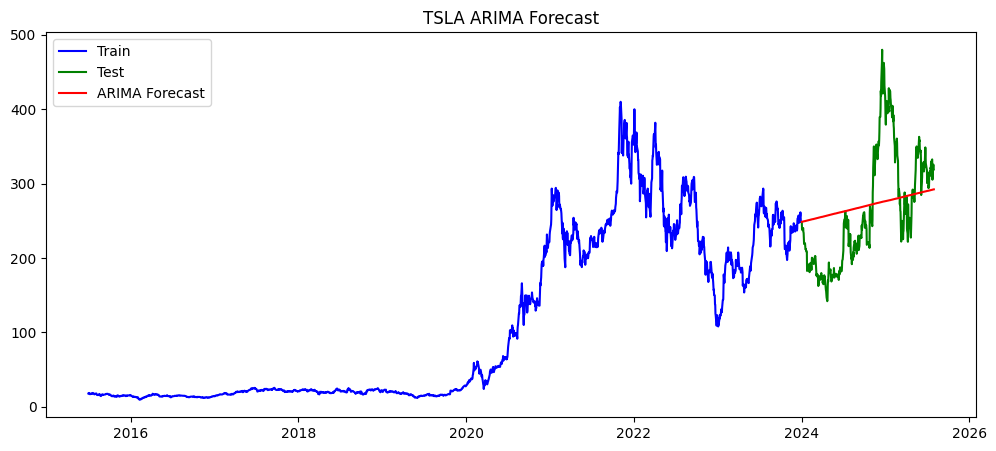

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


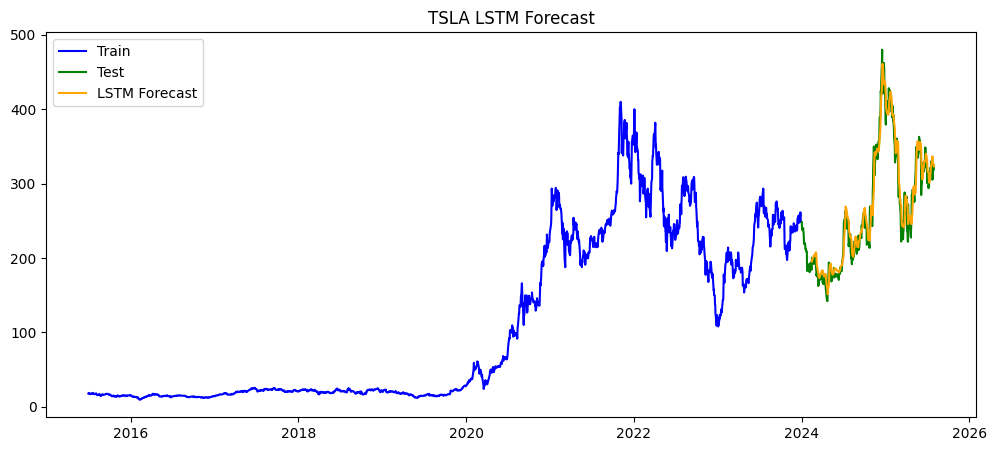

C:\Users\hp\AppData\Local\Temp\ipykernel_21512\111671378.py:28: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundati

TSLA ARIMA MAE: 57.89, RMSE: 69.18, MAPE: nan
TSLA LSTM MAE: 12.50, RMSE: 16.28, MAPE: 4.84

--- BND ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecast

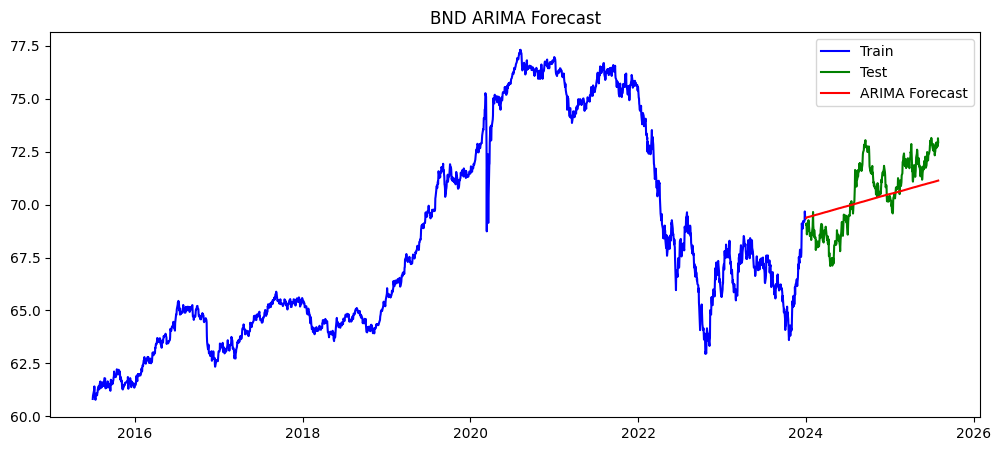

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


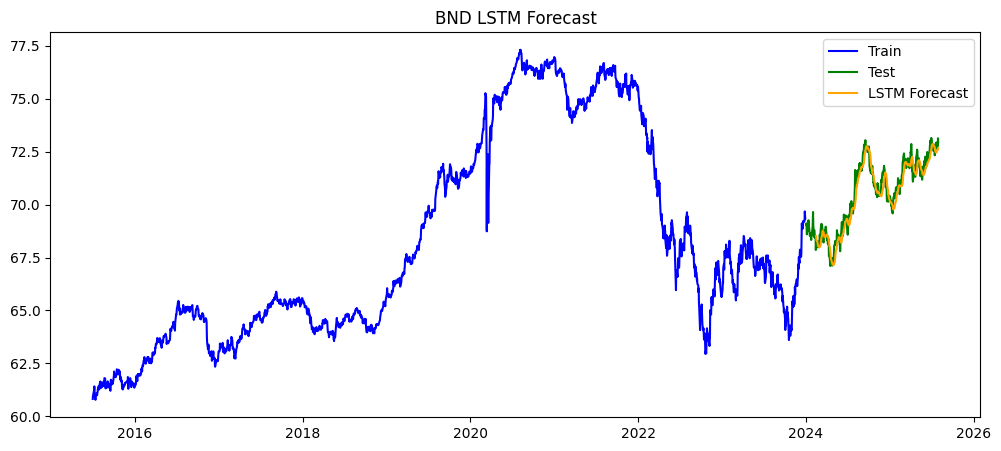

C:\Users\hp\AppData\Local\Temp\ipykernel_21512\111671378.py:28: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundati

BND ARIMA MAE: 1.10, RMSE: 1.28, MAPE: nan
BND LSTM MAE: 0.34, RMSE: 0.42, MAPE: 0.48

--- SPY ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecast

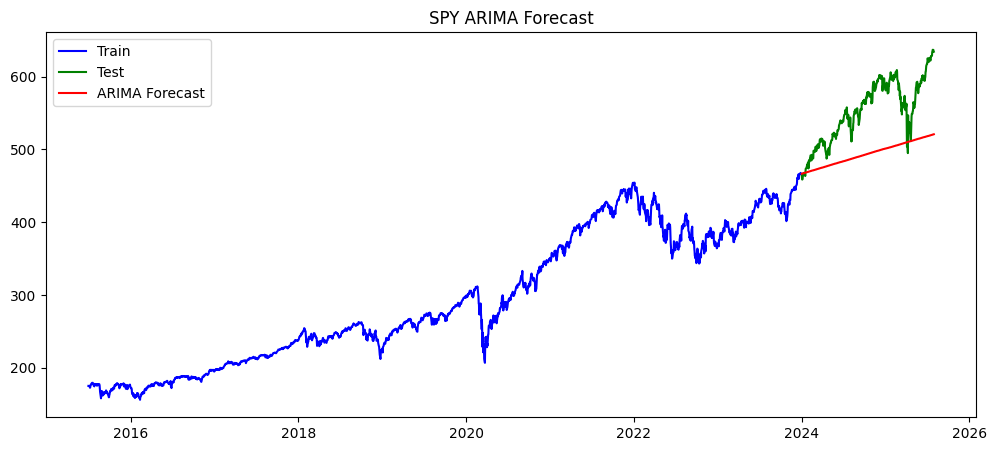

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


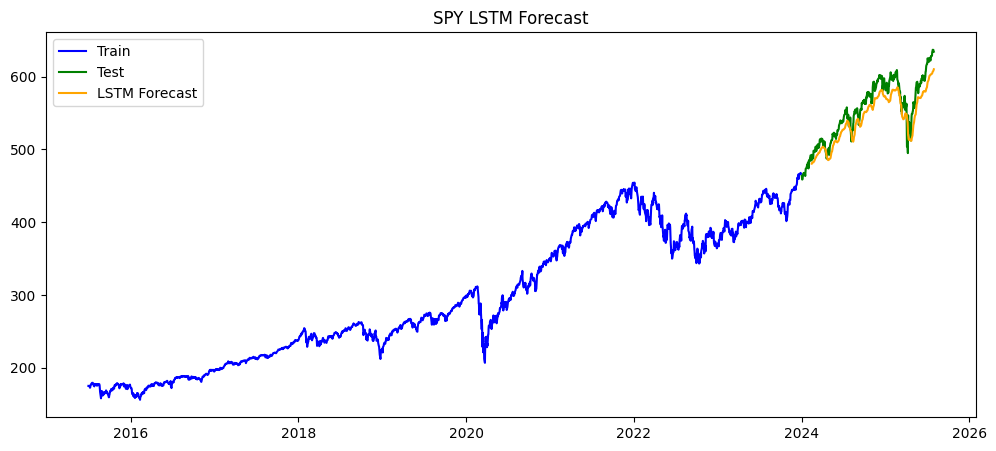

SPY ARIMA MAE: 59.01, RMSE: 66.19, MAPE: nan
SPY LSTM MAE: 16.75, RMSE: 18.66, MAPE: 2.96


C:\Users\hp\AppData\Local\Temp\ipykernel_21512\111671378.py:28: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
for ticker in tickers:
    print(f"\n--- {ticker} ---")
    asset = data[ticker].dropna()
    run_models_and_plot(asset, ticker)